In [3]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [7]:
salary = pd.read_csv('WAG_C_M.csv', delimiter=";", index_col=['month'], parse_dates=['month'], dayfirst=True)

In [8]:
salary.describe()

,WAG_C_M
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


In [31]:
salary.tail()

,WAG_C_M,salary_box,salary_box_diff,salary_box_diff2,model
month,,,,,
2016-04-01,36497000.0,367.830295,5.807535,-2.255980,3.725098e+07
2016-05-01,37270000.0,369.886000,7.854838,2.047303,3.689900e+07
2016-06-01,38447000.0,372.956584,8.113137,0.258299,3.874491e+07
2016-07-01,35888000.0,366.188017,5.505321,-2.607816,3.731375e+07
2016-08-01,34095000.0,361.230520,5.523487,0.018166,3.466652e+07


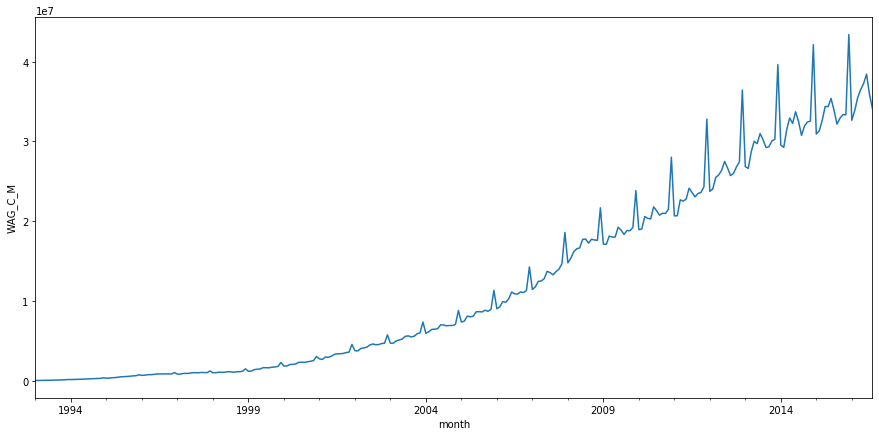

In [10]:
salary.WAG_C_M = salary.WAG_C_M * 1000
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

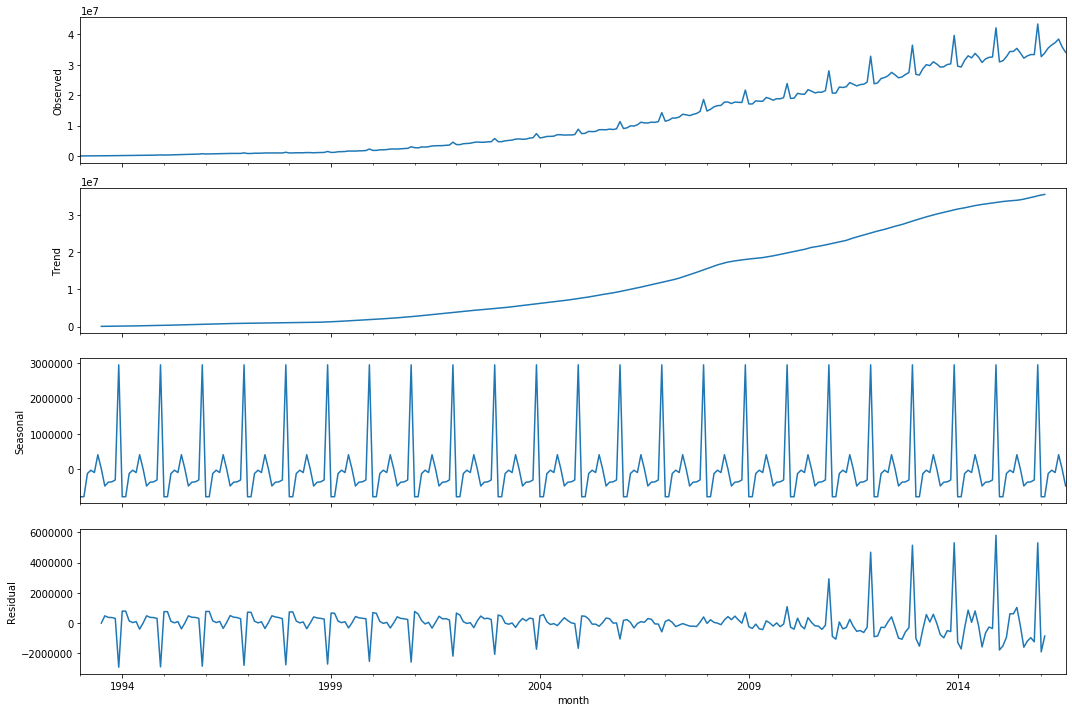

In [11]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

### Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


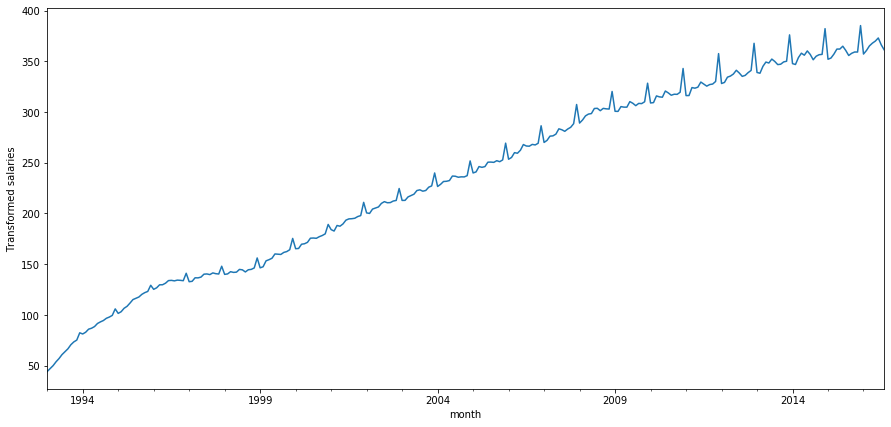

In [12]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

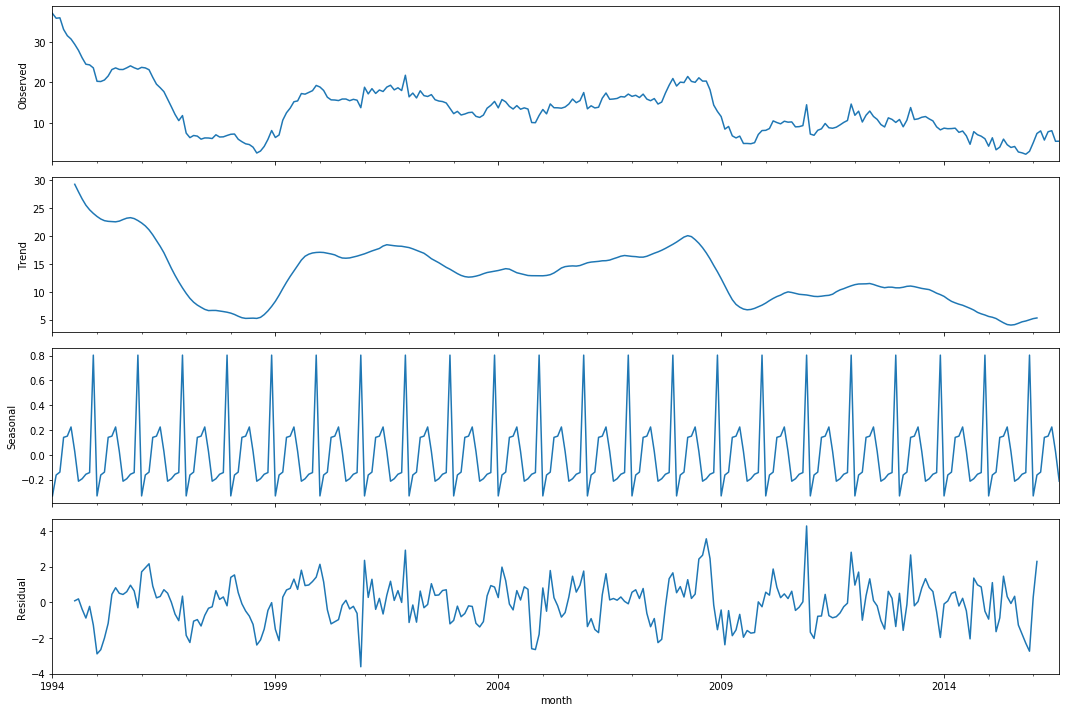

In [13]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности при уровне значимости 0,05. Посмотрим, можно ли лучше, если применить обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

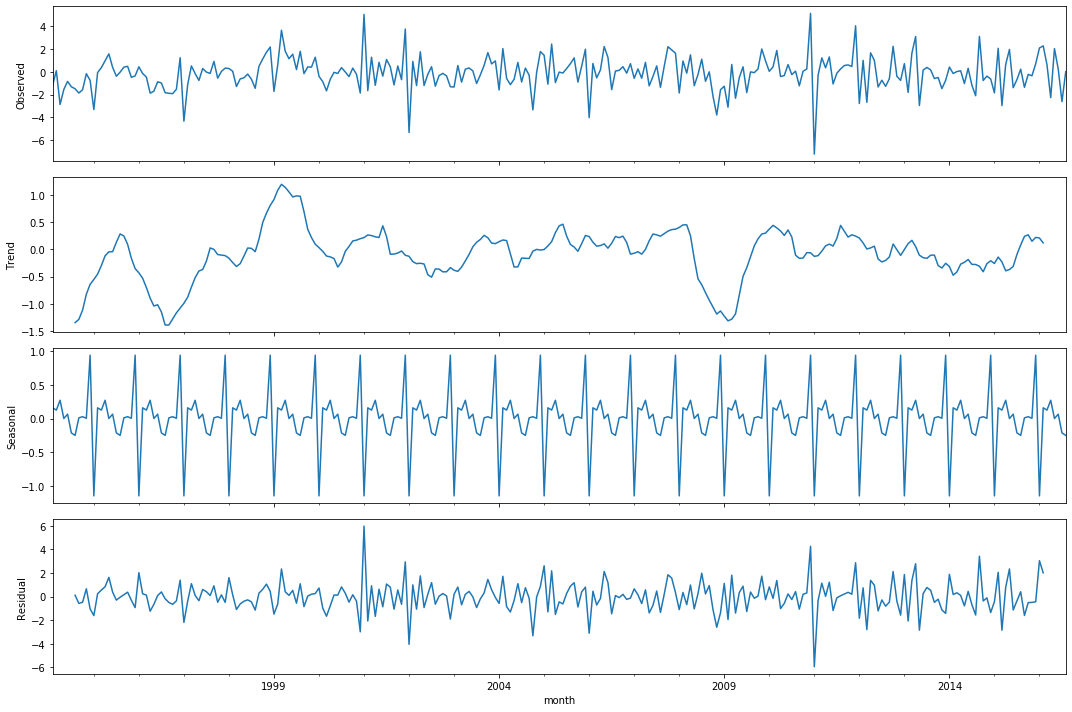

In [14]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, тренда нет.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

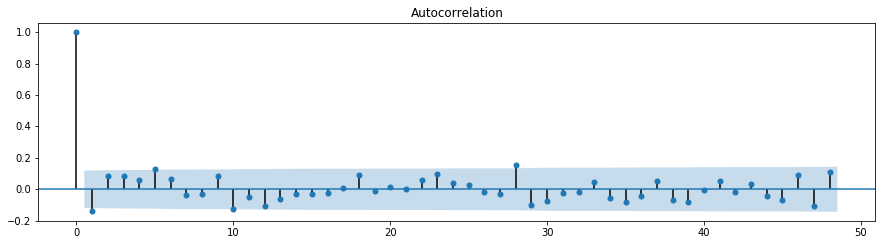

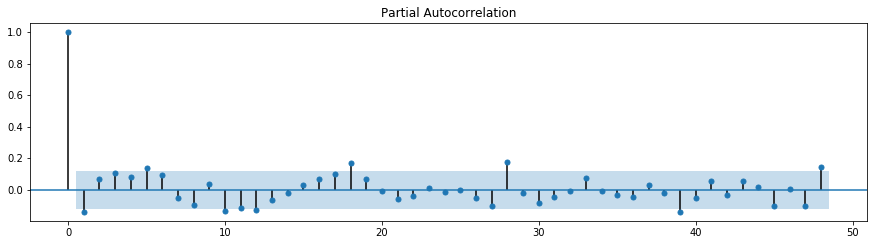

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=5

In [19]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [20]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2min 3s, sys: 16.8 s, total: 2min 19s
Wall time: 32.1 s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
32  (2, 2, 0, 0)  963.939353
34  (2, 2, 1, 0)  963.954511
33  (2, 2, 0, 1)  964.187868
35  (2, 2, 1, 1)  964.374863
44  (3, 2, 0, 0)  965.164528


In [23]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -476.970
Date:                            Thu, 02 Apr 2020   AIC                            963.939
Time:                                    17:13:12   BIC                            981.950
Sample:                                01-01-1993   HQIC                           971.171
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.951      0.000       1.400       1.571
ar.L2         -0.6839      0.043   

Её остатки:

Критерий Стьюдента: p=0.269828
Критерий Дики-Фуллера: p=0.000000


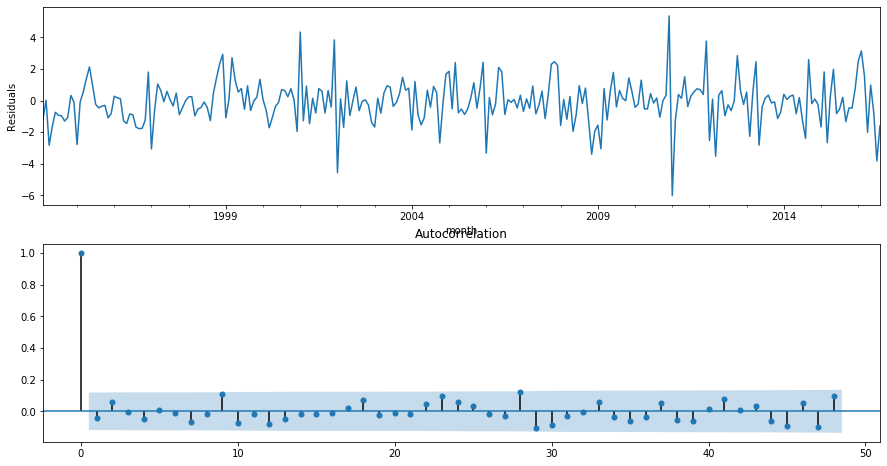

In [24]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

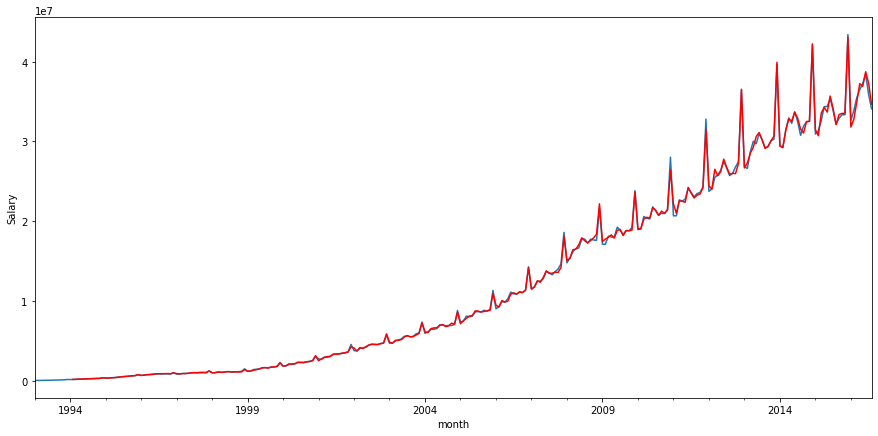

In [26]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Прогноз

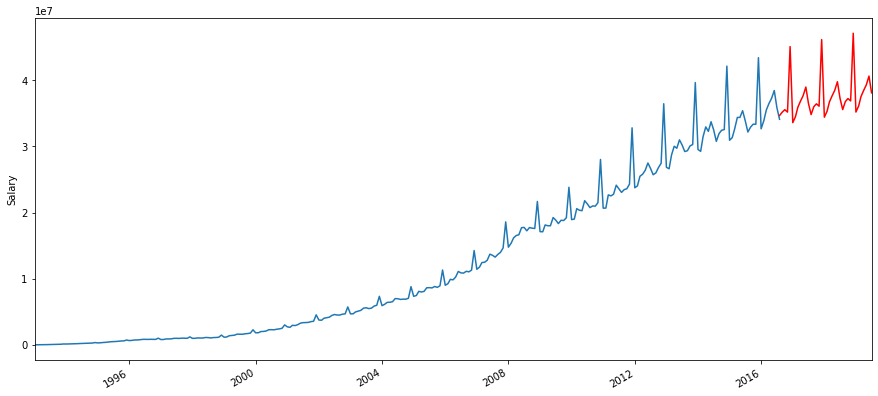

In [37]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=283, end=319), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()